In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
import warnings; warnings.simplefilter('ignore')

In [4]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set

### Collect data

In [5]:
DATASET_ID = 'Budka_crex_crex_segmented'

In [6]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [7]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'corncrake.pickle'
df_loc

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/syllable_dfs/Budka_crex_crex_segmented/corncrake.pickle')

In [8]:
syllable_df = pd.read_pickle(df_loc)

In [9]:
syllable_df[:3]

,start_time,end_time,indv,indvi,key,audio,rate,spectrogram
0,4.362,4.548,89460,0,Crex_crex_89460_short,"[0.10037928866469231, 0.1710392228558546, 0.16...",44100,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,6.162,6.319,89460,0,Crex_crex_89460_short,"[-0.015987384700499978, 0.0009605959436384295,...",44100,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
0,0.282,0.451,89490,0,Crex_crex_89490_short,"[0.0011467438984542739, -0.0008012976130073815...",44100,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [38]:
top_indv = pd.DataFrame({i:[np.sum(syllable_df.indv == i)] for i in  syllable_df.indv.unique()}).T.sort_values(by=0, ascending=False)[:20].T
top_indv

,89519,89354,89524,89531,89527,89358,89361,89362,89374,89454,89427,89515,89383,89439,89569,89453,89436,89462,89466,89562
0,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41


In [10]:
len(syllable_df)

5975

Text(0.5, 1.0, 'min')

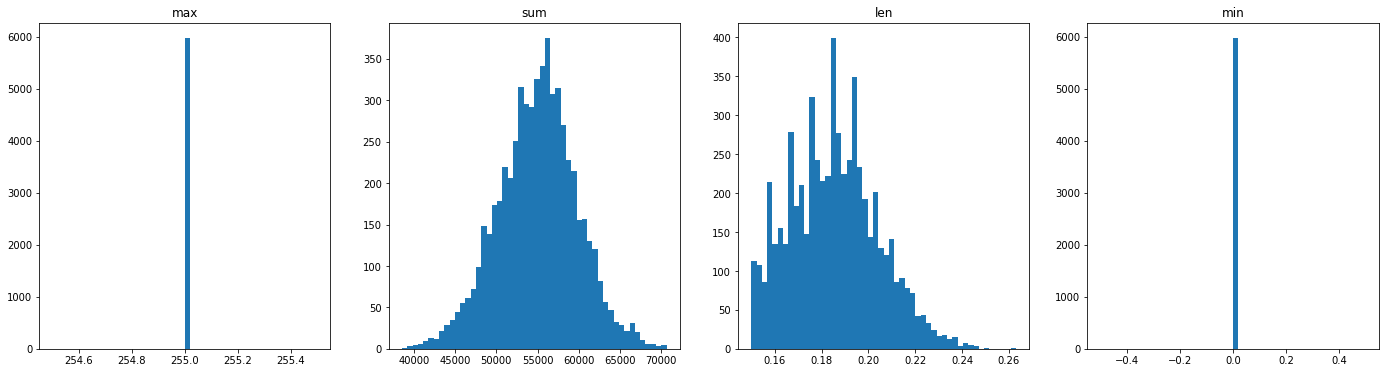

In [11]:
fig, axs = plt.subplots(ncols=4, figsize=(24,6))
axs[0].hist([np.max(i) for i in syllable_df.spectrogram.values], bins=50);axs[0].set_title('max')
axs[1].hist([np.sum(i) for i in syllable_df.spectrogram.values], bins=50);axs[1].set_title('sum')
axs[2].hist((syllable_df.end_time - syllable_df.start_time).values, bins = 50); axs[2].set_title('len')
axs[3].hist([np.min(i) for i in syllable_df.spectrogram.values], bins=50);axs[3].set_title('min')

### cluster

In [12]:
len(syllable_df)

5975

In [13]:
def norm(x):
    return (x-np.min(x)) / (np.max(x) - np.min(x))

In [14]:
specs = list(syllable_df.spectrogram.values)
specs = [norm(i) for i in specs]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(5975, 704)

(25.0, 10) (320, 800) 25.0 32 800


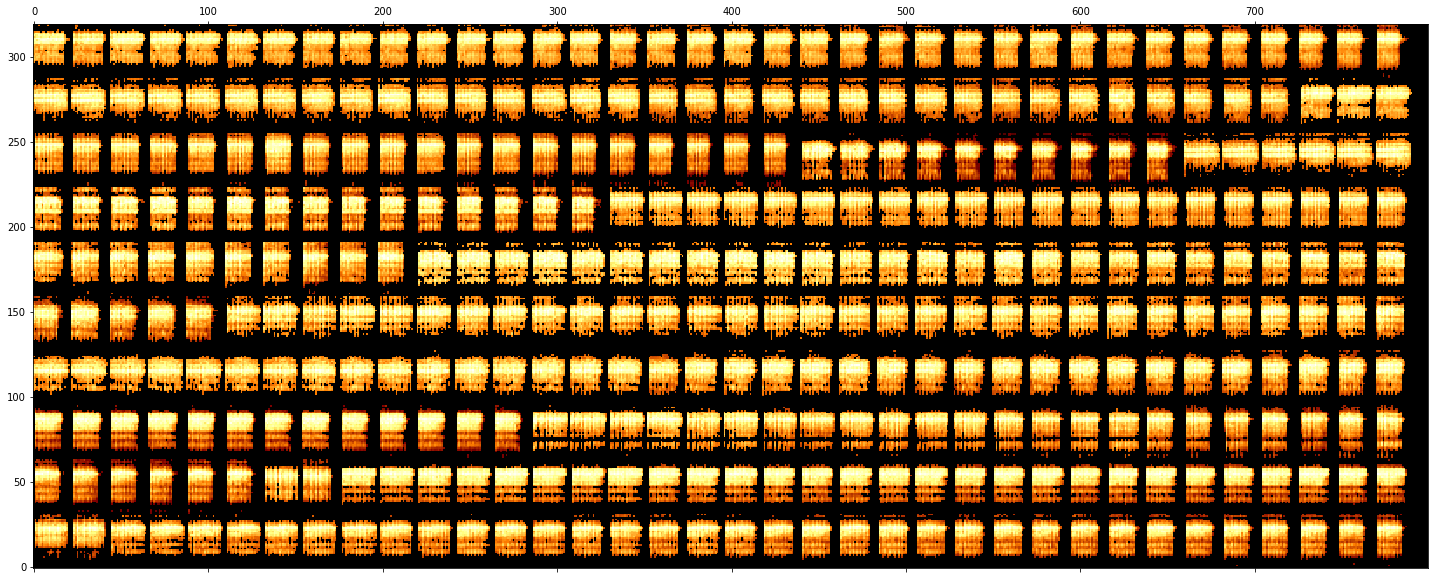

In [15]:
draw_spec_set(specs, zoom=1, maxrows=10, colsize=25)

In [ ]:
### varoatopm across individuals

In [19]:
specs = list(syllable_df.spectrogram.values)
specs = [i / np.max(i) for i in specs]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(5975, 704)

In [20]:
fit = umap.UMAP(min_dist=0.25)

In [21]:
np.shape(specs_flattened)

(5975, 704)

In [22]:
z  = list(fit.fit_transform(specs_flattened))

In [23]:
z = np.vstack(z)

In [25]:
??scatter_projections

(-15, 15)

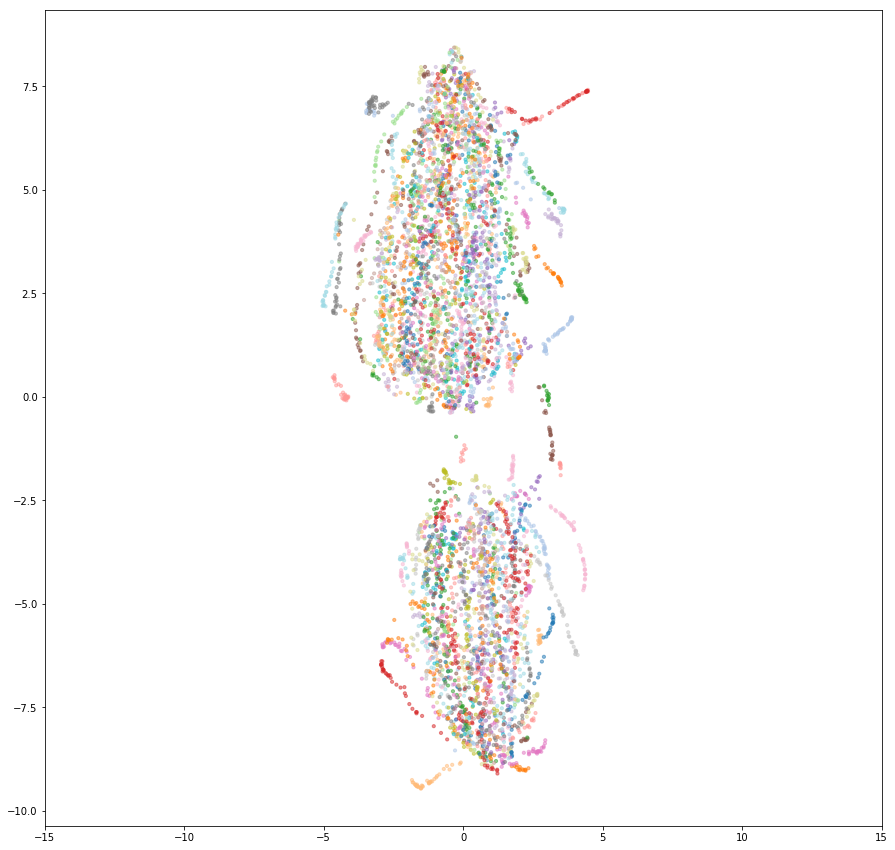

In [27]:
fig, ax = plt.subplots(figsize=(15,15))
scatter_projections(projection=z, alpha=.5, labels = syllable_df.indv.values, s=10, ax = ax, show_legend=False)
ax.set_xlim([-15,15])

In [75]:
z[syllable_df.indv.values == '89524']

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2050 but corresponding boolean dimension is 5975

### subset syllable df

In [67]:
top_indv = (
    pd.DataFrame(
        {i: [np.sum(syllable_df.indv == i)] for i in syllable_df.indv.unique()}
    )
    .T.sort_values(by=0, ascending=False)[:50]
    .T
)
top_indv

,89519,89354,89524,89531,89527,89358,89361,89362,89374,89454,...,89489,89432,89375,89530,89359,89526,89532,89504,89545,89567
0,41,41,41,41,41,41,41,41,41,41,...,41,41,41,41,41,41,41,41,41,41


### individuality
- https://onlinelibrary.wiley.com/doi/epdf/10.1111/j.1474-919X.1998.tb04548.x

In [68]:
subset_df = syllable_df[syllable_df.indv.isin(list(top_indv.columns))]
subset_df[:3]

,start_time,end_time,indv,indvi,key,audio,rate,spectrogram
0,0.416,0.606,89567,0,Crex_crex_89567_short,"[-0.005477330804152156, -0.017505483754491048,...",44100,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0.939,1.142,89567,0,Crex_crex_89567_short,"[0.0245098985354733, 0.1272105120212481, 0.224...",44100,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,1.592,1.788,89567,0,Crex_crex_89567_short,"[0.02153232316568807, 0.05382163259806454, 0.0...",44100,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [69]:
specs = list(subset_df.spectrogram.values)
specs = [i / np.max(i) for i in specs]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(2050, 704)

In [70]:
fit = umap.UMAP(min_dist=0.25)

In [71]:
np.shape(specs_flattened)

(2050, 704)

In [72]:
z  = list(fit.fit_transform(specs_flattened))

In [73]:
z = np.vstack(z)

(-15, 15)

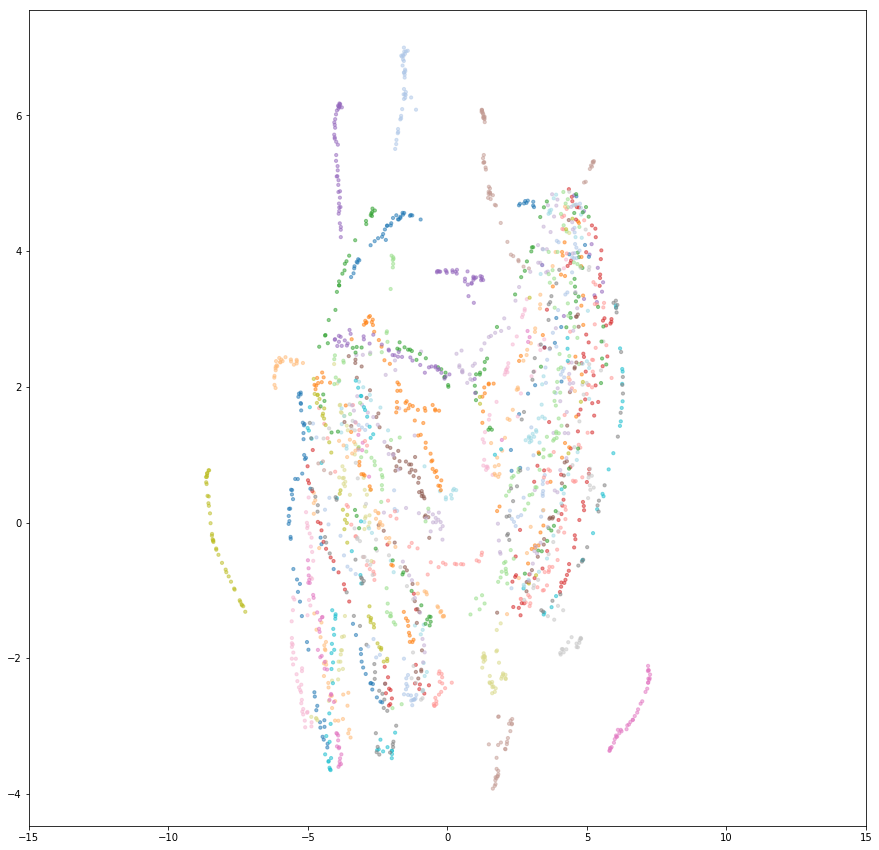

In [74]:
fig, ax = plt.subplots(figsize=(15,15))
scatter_projections(projection=z, alpha=.5, labels = subset_df.indv.values, s=10, ax = ax, show_legend=False)
ax.set_xlim([-15,15])